In [13]:
import pandas as pd
from matplotlib import pyplot as plt
import nltk
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from factor_analyzer import FactorAnalyzer
import random
import seaborn as sns
random.seed(30)

## Create the Fake Customer Purchase data

In [2]:
X, y = make_blobs(n_samples=10000, centers=5, n_features=6,
                 random_state=0)

df_products = pd.DataFrame(data=X,
                           columns=['product_desc_' + str(x) for x in range(0, 6)])
df_products['Product_Class'] = y
df_products['Product_ID'] = df_products.index

X, y = make_blobs(n_samples=1000, centers=10, n_features=8,
                 random_state=0)

df_customer = pd.DataFrame(data=X,
                           columns=['customer_desc_' + str(x) for x in range(0, 8)])

df_customer['Customer_Class'] = y
df_customer['Customer_ID'] = df_customer.index

# Randomly Select some of the customers to pair with random purchases
day1 = pd.DataFrame(zip([random.randint(0, 1000) for x in range(0, 500)],
                [random.randint(0, 10000) for x in range(0, 500)]), columns=['Customer_ID', 'Product_ID'])

day2 = pd.DataFrame(zip([random.randint(0, 1000) for x in range(0, 500)],
                [random.randint(0, 10000) for x in range(0, 500)]), columns=['Customer_ID', 'Product_ID'])

purchases = pd.concat([day1, day2], axis=0, ignore_index=True)
purchases.head()

,Customer_ID,Product_ID
0,552,773
1,827,8608
2,296,518
3,625,5394
4,30,8543


In [3]:
df_purchases = None
for purchase in range(0, len(purchases)):
    cust_id = purchases['Customer_ID'][purchase]
    prod_id = purchases['Product_ID'][purchase]
    cust_features = df_customer[df_customer['Customer_ID'] == cust_id]
    cust_features.reset_index(inplace=True, drop=True)
    prod_features = df_products[df_products['Product_ID'] == prod_id]
    prod_features.reset_index(inplace=True, drop=True)
    temp = pd.concat([prod_features, cust_features], axis=1)
    if df_purchases is None:
        df_purchases = pd.concat([prod_features, cust_features], axis=1)
    else:
        df_purchases = df_purchases.append(pd.concat([prod_features, cust_features], axis=1))
df_purchases.reset_index(inplace=True, drop=True)
df_purchases

,product_desc_0,product_desc_1,product_desc_2,product_desc_3,product_desc_4,product_desc_5,Product_Class,Product_ID,customer_desc_0,customer_desc_1,customer_desc_2,customer_desc_3,customer_desc_4,customer_desc_5,customer_desc_6,customer_desc_7,Customer_Class,Customer_ID
0,-1.233276,8.747108,9.165746,-0.007541,4.652380,1.913970,1,773,-6.374916,-2.257586,7.688019,-7.992522,7.593467,-9.193683,10.376847,-0.388405,8.0,552.0
1,-0.170403,8.219852,9.710727,-1.550177,5.811414,1.492459,1,8608,9.294317,-2.231715,6.061894,-0.438840,1.246116,8.820684,-9.950039,-7.391761,1.0,827.0
2,-2.822567,8.036298,10.929105,-0.935760,6.077699,1.265250,1,518,-8.793580,4.805865,6.167272,5.770659,7.451190,4.144325,1.196351,5.414350,2.0,296.0
3,1.019780,6.766354,-9.152836,-8.611808,-8.749707,6.637419,2,5394,-7.047638,-2.131113,5.768863,-8.094387,6.223832,-8.834962,9.629384,-1.935227,8.0,625.0
4,4.321656,7.430975,8.847703,5.921750,-0.868445,5.483210,3,8543,-0.169121,1.346768,-10.211423,1.709859,1.655568,1.891809,7.856076,4.333816,4.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2.151425,3.179085,2.337353,0.559543,-1.629433,2.493002,0,8383,-4.926378,-1.474424,2.848533,-10.733950,4.237231,5.048239,-5.263423,-7.005510,5.0,272.0
996,0.475735,4.378010,2.597665,1.569648,-1.131376,3.110801,0,6141,7.821350,-1.948967,6.039587,1.739432,2.351800,8.325224,-10.263796,-7.450850,1.0,616.0
997,4.621406,7.791088,8.592775,6.423716,0.915721,4.727899,3,406,-9.236352,2.760513,-7.290240,9.169618,-0.188279,-2.443252,-4.153840,6.140598,3.0,266.0
998,-1.720297,8.174031,9.746428,-1.849028,5.046019,0.951072,1,9737,-1.411479,0.830250,5.167232,-9.188249,3.176105,4.570698,-6.300042,-7.561958,5.0,263.0


/Users/nathanielforde/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


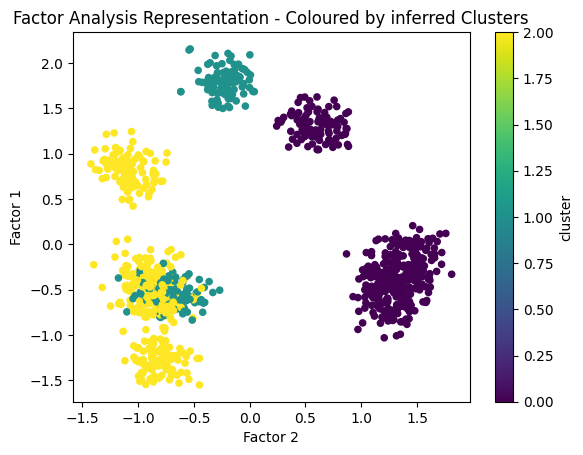

In [6]:
X = df_customer[[x for x in df_purchases.columns if 'customer_desc' in x]]
kmeans = KMeans(init='k-means++', n_clusters=3, n_init=30)
kmeans.fit(X)
clusters = kmeans.predict(X)
X['cluster'] = clusters
from sklearn.decomposition import FactorAnalysis
sklearn_fa = FactorAnalysis(n_components=2, rotation='varimax')
Y_fa = pd.DataFrame(sklearn_fa.fit_transform(X[[col for col in X.columns if
                                         not 'cluster' in col]]))
X = pd.concat([X, Y_fa], axis=1)
X[[0, 1, 'cluster']].plot.scatter(x=0,
                      y=1,
                      c='cluster',
                      colormap='viridis')
plt.title("Factor Analysis Representation - Coloured by inferred Clusters")
plt.ylabel("Factor 1")
plt.xlabel("Factor 2")
plt.style.use('default')
plt.show()

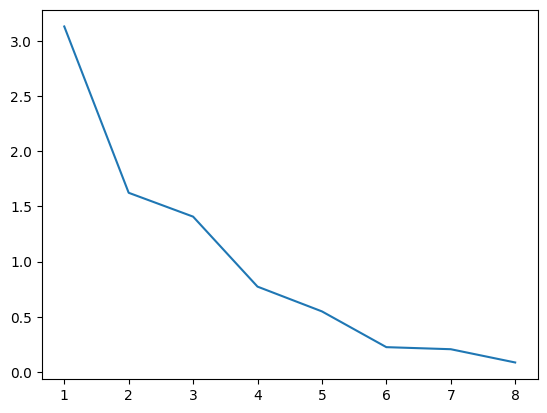

In [38]:
from sklearn.decomposition import FactorAnalysis, PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
feature_names = ['customer_desc_' + str(x) for x in range(0, 8)]

fa = FactorAnalyzer(n_factors=3)
fa.fit(X[feature_names], 10)
ev, v = fa.get_eigenvalues()
plt.plot(range(1,X[feature_names].shape[1]+1),ev)
plt.show()

In [46]:
communalities = pd.DataFrame(fa.get_communalities(), index=list(feature_names))
features_comm = list(communalities[communalities[0] > 0.2].index)
print('Total variables/features with communalities >0.2: {}'.format(len(features_comm)))

Total variables/features with communalities >0.2: 8


In [40]:
fa_loading_matrix = pd.DataFrame(fa.loadings_, columns=['FA{}'.format(i) for i in range(1, 3+1)], 
                              index=feature_names)
fa_loading_matrix['Highest_loading'] = fa_loading_matrix.idxmax(axis=1)
fa_loading_matrix = fa_loading_matrix.sort_values('Highest_loading')
fa_loading_matrix

,FA1,FA2,FA3,Highest_loading
customer_desc_1,0.727724,0.024771,0.091443,FA1
customer_desc_3,0.826998,0.068252,0.014691,FA1
customer_desc_5,0.637687,-0.003234,0.489801,FA1
customer_desc_7,0.787048,0.081877,-0.414776,FA1
customer_desc_4,0.015911,1.001115,0.175406,FA2
customer_desc_6,-0.172587,0.077989,-0.684129,FA2
customer_desc_0,-0.229668,-0.628541,0.355323,FA3
customer_desc_2,-0.304156,0.217303,0.440891,FA3


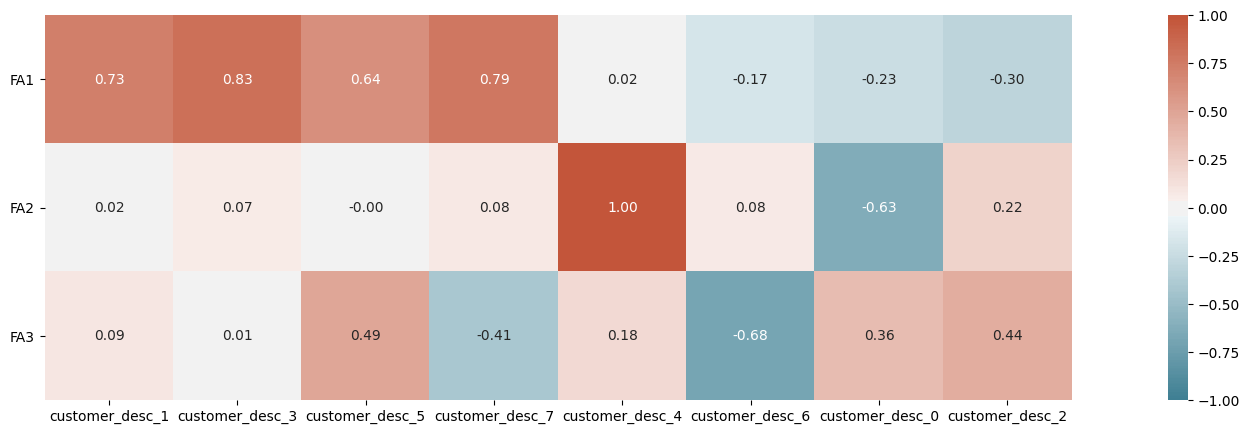

In [41]:
import seaborn as sns

plt.figure(figsize=(25,5))

# plot the heatmap for correlation matrix
ax = sns.heatmap(fa_loading_matrix.drop('Highest_loading', axis=1).T, 
                vmin=-1, vmax=1, center=0,
                cmap=sns.diverging_palette(220, 20, n=200),
                square=True, annot=True, fmt='.2f')

ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=0);

In [43]:
import pingouin as pg
#Create the factors
factor1 = X[['customer_desc_1', 'customer_desc_3', 'customer_desc_5', 'customer_desc_7']]
factor2 = X[['customer_desc_4', 'customer_desc_0']]
factor3 = X[['customer_desc_5', 'customer_desc_6', 'customer_desc_2']]
#Get cronbach alpha
factor1_alpha = pg.cronbach_alpha(factor1)
factor2_alpha = pg.cronbach_alpha(factor2)
factor3_alpha = pg.cronbach_alpha(factor3)
print(factor1_alpha, factor2_alpha, factor3_alpha)

(0.7889764629492506, array([0.767, 0.81 ])) (-3.3829592302251275, array([-3.962, -2.871])) (-0.8158399732248113, array([-1.02 , -0.629]))
